# Exploratory Data Analysis

This notebook is a applies concepts mentioned in my blog section on:

- **Variable types** 
    - (categorical vs numerical; nominal vs ordinal; discrete vs continuous)
- **Data health checks** 
    - (missing values, frequency/rates, class imbalance)
- **Summary statistics** 
    - (mean/median/variance/quartiles/min/max)
- **Distribution characterization** 
    - (shape, center, spread, outliers via IQR)
- **Fixing / preprocessing** 
    - (scaling + standardization)
- **Visualization** 
    - (histograms, KDE-ish smoothing, box plots)


> CSV used is from kaggle, a flower dataset 
    >https://www.kaggle.com/datasets/abhayayare/flower-dataset 

> Further explination on 
    > Link
---


### NumPy (Numerical Computing Backbone)
> Math engine of machine learning in python 
- ndarrays: a key data structure designed for efficent storage of large datasets
    - Types within the array must be the same (must encode categorical data)
    - can represent any number of dimensions 
    - acts like a vector in math operations 
- Broadcasting: allows you to do math between diffrent array shapes
- Linear algebra: allows you to carry out operations 
- Random distributions: allows you to generate randomized, simulate, and sample data
### Pandas (data handling)
> Structured data manipulation algorithums built ontop of NumPy
- DataFrame: Organizes data into rows and colums, and can handle diffrent types of data across columns
- Samples: allows you to select and filter throught the data
- Groupby: allows you to split into groups, apply a function, and combine the data.  
- Missing Data handling: efficently allows you to handle by droping, or filling 
### Mathplotlib (Visuals generator)
> Library that generates plots based on data / numbers
- Figures: generates histograms, simulates KDE's, creates boxplots. 
- helpful for reveling patterns. 

In [1]:
#Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # for the KDE

Matplotlib is building the font cache; this may take a moment.


## 1. Load the dataset 

Check for diffrent types of data types 
- Cateogrical 
    - Typically strings
- Numerical 
    - the numbers, use worldly knowlage to discern discrete and continous

In [8]:
df = pd.read_csv("flower_dataset.csv")
##df = pd.read_csv("./flower_dataset.csv")
df.head()

,species,size,fragrance,height_cm
0,rose,medium,mild,48.55
1,shoeblack plant,medium,mild,147.07
2,shoeblack plant,medium,none,102.93
3,hibiscus,large,none,184.00
4,shoeblack plant,large,mild,83.07


## 2. Summary statistics 

Inital Computations: 
- Mean
- Median
- Variance & Standard deviation**
- Min / Max
- Q1 & Q3 
- IQR = Q3 - Q1

The summary_stats function iterates over columns, coerces values to numeric (errors="coerce"), drops invalid entries, and computes sample-based variance and standard deviation (ddof=1)

In [9]:
num_cols = ["height_cm"]

def summary_stats(df: pd.DataFrame, cols) -> pd.DataFrame:
    out = {}
    for c in cols:
        s = pd.to_numeric(df[c], errors="coerce").dropna()  # avoid breaking on bad/missing data
        if s.empty:
            continue
        out[c] = {
            "count": int(s.shape[0]),
            "mean": float(s.mean()),
            "median": float(s.median()),
            "var": float(s.var(ddof=1)),
            "std": float(s.std(ddof=1)),
            "min": float(s.min()),
            "q1": float(s.quantile(0.25)),
            "q3": float(s.quantile(0.75)),
            "max": float(s.max()),
        }
        out[c]["iqr"] = out[c]["q3"] - out[c]["q1"]
    return pd.DataFrame(out).T.round(3)

summary_stats(df, num_cols)


,count,mean,median,var,std,min,q1,q3,max,iqr
height_cm,10000.0,104.874,100.51,1904.03,43.635,30.09,69.308,137.022,199.97,67.715


## 3. Distribution analysis
### Health of data 
- Missing data values 
    - Low missingness (<5%): drop rows or impute (mean/median depending on skew)
    - High missingness (>30%): often drop the feature (it may be more noise than signal)
    - 50%: usually drop the feature unless you have a strong reason + special handling

In [10]:
missing = df.isna().mean().sort_values(ascending=False)

missing_table = pd.DataFrame({
    "missing_%": (missing * 100).round(2),
    "rule_of_thumb": pd.cut(
        missing,
        bins=[-0.001, 0.05, 0.30, 0.50, 1.0],
        labels=[
            "Low (<5%) – safe to drop/impute",
            "Medium (5–30%) – investigate",
            "High (30–50%) – likely drop feature",
            "Very High (>=50%) – drop feature"
        ]
    )
})

missing_table

,missing_%,rule_of_thumb
species,0.0,Low (<5%) – safe to drop/impute
size,0.0,Low (<5%) – safe to drop/impute
fragrance,0.0,Low (<5%) – safe to drop/impute
height_cm,0.0,Low (<5%) – safe to drop/impute


- Freqency + rates (categorical)
    - raw counts and relative freqency help spot skew in categories 

In [11]:
def freq_table(series: pd.Series, top_n=10) -> pd.DataFrame:
    counts = series.value_counts(dropna=False).head(top_n)
    rates = (counts / len(series) * 100).round(2)
    return pd.DataFrame({
        "count": counts,
        "rate_%": rates
    })

freq_table(df["species"])
freq_table(df["size"])
freq_table(df["fragrance"])


,count,rate_%
fragrance,,
none,5003,50.03
mild,3327,33.27
strong,1670,16.70


Class imbalance (categorical target)
- If one class dominates, a “dumb” model can get high accuracy by guessing the majority class.

- We’ll quantify imbalance with:
    - majority class rate
    - minority class rate

In [12]:
def class_imbalance_rates(series: pd.Series):
    counts = series.value_counts()
    majority = (counts.max() / counts.sum()) * 100
    minority = (counts.min() / counts.sum()) * 100
    return round(majority, 2), round(minority, 2)

class_imbalance_rates(df["species"])


(np.float64(33.45), np.float64(33.18))

## 4. Distribution Characterization
- Shape 
    - If **mean > median**, distribution tends to be **right-skewed**
    - If **mean < median**, distribution tends to be **left-skewed**
    - If **mean ≈ median**, distribution is closer to symmetric
- Outliners 
    - **IQR = Q3 - Q1**
    - Lower bound = Q1 - 1.5·IQR  
    - Upper bound = Q3 + 1.5·IQR

In [13]:
num_cols = ["height_cm"]

shape_hint = []
for c in num_cols:
    s = pd.to_numeric(df[c], errors="coerce").dropna()
    if s.empty:
        continue

    mean = float(s.mean())
    median = float(s.median())

    if np.isclose(mean, median, rtol=0.02):
        hint = "roughly symmetric (mean ~ median)"
    elif mean > median:
        hint = "right-skew hint (mean > median)"
    else:
        hint = "left-skew hint (mean < median)"

    shape_hint.append((c, mean, median, hint))

pd.DataFrame(shape_hint, columns=["feature", "mean", "median", "shape_hint"]).round(3)

,feature,mean,median,shape_hint
0,height_cm,104.874,100.51,right-skew hint (mean > median)


In [14]:
def iqr_outliers(series: pd.Series) -> pd.DataFrame:
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty:
        return pd.DataFrame()

    q1 = float(s.quantile(0.25))
    q3 = float(s.quantile(0.75))
    iqr = q3 - q1
    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr

    mask = (s < lo) | (s > hi)

    return pd.DataFrame({
        "q1": [q1],
        "q3": [q3],
        "iqr": [iqr],
        "lower": [lo],
        "upper": [hi],
        "outlier_count": [int(mask.sum())],
        "outlier_rate_%": [float(mask.mean() * 100)]
    }).round(3)

iqr_outliers(df["height_cm"])

outlier_reports = []
for c in num_cols:
    r = iqr_outliers(df[c])
    if not r.empty:
        r.insert(0, "feature", c)
        outlier_reports.append(r)

pd.concat(outlier_reports, ignore_index=True) if outlier_reports else pd.DataFrame()


,feature,q1,q3,iqr,lower,upper,outlier_count,outlier_rate_%
0,height_cm,69.308,137.022,67.715,-32.265,238.595,0,0.0


## 5. Preprocssesing 
If one feature ranges 60–200 and another is 0–1, many models will “feel” the larger one more strongly.

shows:
- **Min–Max scaling** (maps values to [0,1])
- **Standardization (Z-scores)** (mean 0, std 1)
- Our flower dataset only has one numeric feature (height_cm), but we still demonstrate scaling because it becomes critical once you have multiple numeric features.

In [15]:
import numpy as np
import pandas as pd

df_clean = df.copy()

# Treat impossible / suspicious heights as missing (adjust bounds if needed)
df_clean.loc[(df_clean["height_cm"] < 5) | (df_clean["height_cm"] > 400), "height_cm"] = np.nan

# Impute height using median (robust to outliers)
height_median = df_clean["height_cm"].median()
df_clean["height_cm"] = df_clean["height_cm"].fillna(height_median)

df_clean[["height_cm"]].describe().T


,count,mean,std,min,25%,50%,75%,max
height_cm,10000.0,104.873938,43.635191,30.09,69.3075,100.51,137.0225,199.97


In [16]:
def minmax_scale(x: pd.Series) -> pd.Series:
    x = pd.to_numeric(x, errors="coerce")
    lo, hi = x.min(), x.max()
    if pd.isna(lo) or pd.isna(hi) or lo == hi:
        return x * 0  # degenerate case
    return (x - lo) / (hi - lo)

def zscore(x: pd.Series) -> pd.Series:
    x = pd.to_numeric(x, errors="coerce")
    mu, sd = x.mean(), x.std(ddof=1)
    if pd.isna(mu) or pd.isna(sd) or sd == 0:
        return x * 0
    return (x - mu) / sd

df_scaled = df_clean.copy()
df_scaled["height_minmax"] = minmax_scale(df_scaled["height_cm"])
df_scaled["height_z"] = zscore(df_scaled["height_cm"])

df_scaled[["height_cm", "height_minmax", "height_z"]].head()


,height_cm,height_minmax,height_z
0,48.55,0.108665,-1.290792
1,147.07,0.688604,0.967019
2,102.93,0.428773,-0.044550
3,184.00,0.905992,1.813354
4,83.07,0.311867,-0.499687


## 6. Encoding categorical variable 
Computers prefer numbers. Encoding turns categories into numeric representations.

Common encodings:
- One-Hot Encoding 
    - (nominal; no order)
- Ordinal Encoding
    - (ordered categories)
- Target encoding 
    - (riskier; can leak target info if done wrong)

We’ll implement one-hot for `key`, and ordinal for `mood`.

In [17]:
# One-hot encode nominal columns
df_encoded = df_scaled.copy()

onehot_cols = ["species", "fragrance"]
df_onehot = pd.get_dummies(df_encoded[onehot_cols], prefix=onehot_cols, dummy_na=True)

# Ordinal encode size (small < medium < large)
size_order = {"small": 0, "medium": 1, "large": 2}
df_encoded["size_ord"] = df_encoded["size"].map(size_order)

# Combine: drop original nominal cols, attach one-hot
df_encoded = pd.concat([df_encoded.drop(columns=onehot_cols), df_onehot], axis=1)

# Preview: show original categorical + ordinal + a few one-hot cols
show_cols = ["size", "size_ord", "height_cm", "height_minmax", "height_z"] + list(df_onehot.columns[:6])
df_encoded[show_cols].head()


,size,size_ord,height_cm,height_minmax,height_z,species_hibiscus,species_rose,species_shoeblack plant,species_nan,fragrance_mild,fragrance_none
0,medium,1,48.55,0.108665,-1.290792,False,True,False,False,True,False
1,medium,1,147.07,0.688604,0.967019,False,False,True,False,True,False
2,medium,1,102.93,0.428773,-0.044550,False,False,True,False,False,True
3,large,2,184.00,0.905992,1.813354,True,False,False,False,False,True
4,large,2,83.07,0.311867,-0.499687,False,False,True,False,True,False


## 7. Visualization 
- Histograms 
    - Good for spotting:
    - center
    - skew
    - spread
    - weird bumps (multi-modality)
- KDE 
    - Make a histogram density
    - Smooth it with a small gaussian kernel (convolution)
- Box plot 
    - median (center line)
    - middle 50% (box: Q1 to Q3)
    - whiskers (range excluding outliers by rule)
    - outliers (points)

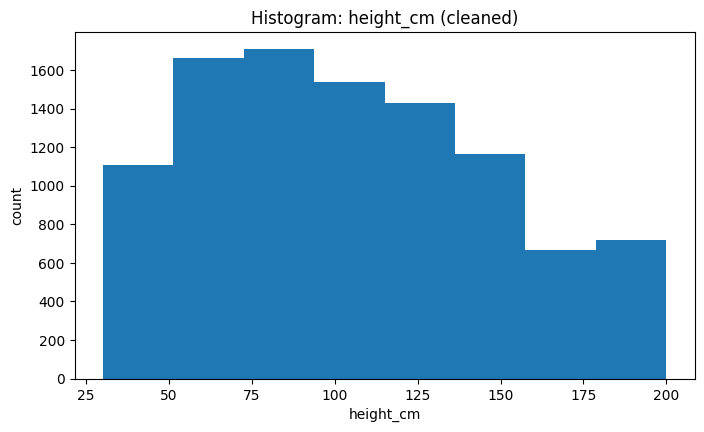

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

def hist_plot(series: pd.Series, title: str, bins=10):
    s = pd.to_numeric(series, errors="coerce").dropna()
    plt.figure(figsize=(8, 4.5))
    plt.hist(s, bins=bins)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("count")
    plt.show()

hist_plot(df_clean["height_cm"], "Histogram: height_cm (cleaned)", bins=8)


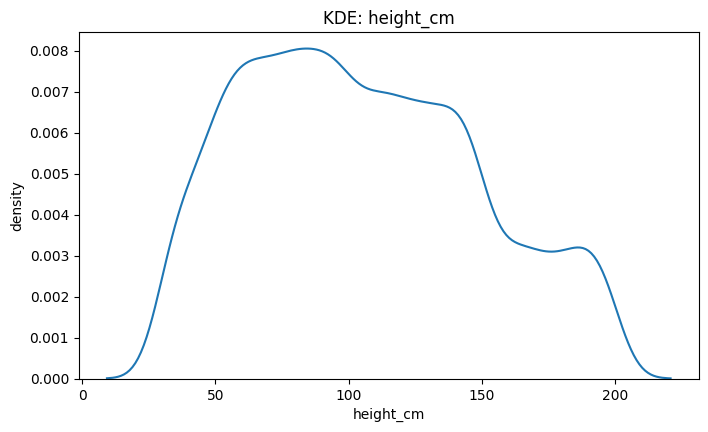

In [19]:


s = pd.to_numeric(df_clean["height_cm"], errors="coerce").dropna()

plt.figure(figsize=(8, 4.5))
sns.kdeplot(s, fill=False)  # set fill=True if you want shading
plt.title("KDE: height_cm")
plt.xlabel("height_cm")
plt.ylabel("density")
plt.show()


/var/folders/gh/b033ntcn7dzg0sm5mdtrm2sm0000gn/T/ipykernel_22574/2543285471.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=list(top_cats), showfliers=True)


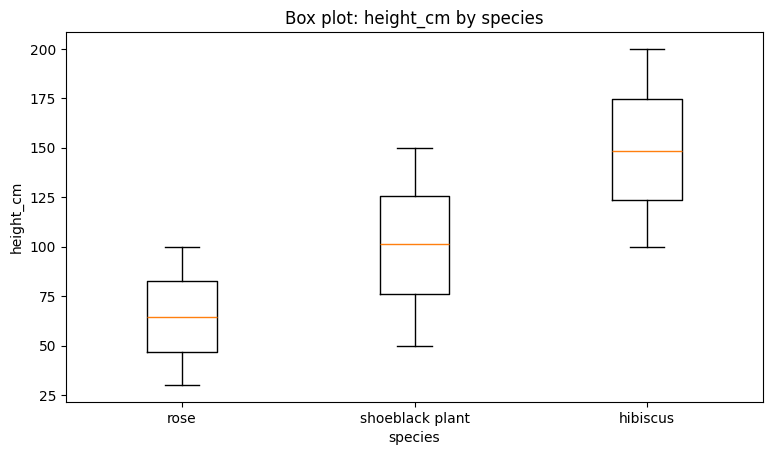

/var/folders/gh/b033ntcn7dzg0sm5mdtrm2sm0000gn/T/ipykernel_22574/2543285471.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=list(top_cats), showfliers=True)


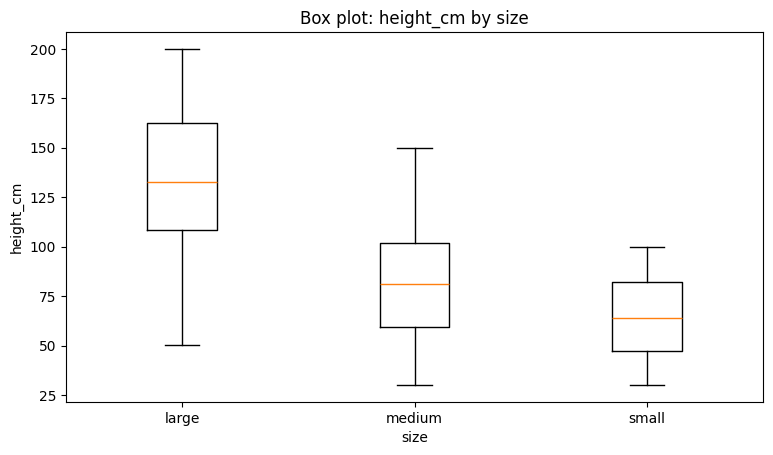

In [20]:
def boxplot_by_category(df: pd.DataFrame, cat_col: str, num_col: str, top_n=10):
    top_cats = df[cat_col].value_counts().head(top_n).index
    d = df[df[cat_col].isin(top_cats)]

    data = [
        pd.to_numeric(d.loc[d[cat_col] == c, num_col], errors="coerce").dropna()
        for c in top_cats
    ]

    plt.figure(figsize=(9, 4.8))
    plt.boxplot(data, labels=list(top_cats), showfliers=True)
    plt.title(f"Box plot: {num_col} by {cat_col}")
    plt.xlabel(cat_col)
    plt.ylabel(num_col)
    plt.show()

boxplot_by_category(df_clean, "species", "height_cm")
boxplot_by_category(df_clean, "size", "height_cm")

